# Oil and Gas 

Using Colorado oil and gas data at https://cogcc.state.co.us/data2.html#/downloads to calculate scores based on 

* the number of [wells](https://cogcc.state.co.us/documents/data/downloads/gis/metadata/Oil_and_Gas_Locations_Metadata.html) , [pits](https://cogcc.state.co.us/documents/data/downloads/gis/metadata/Pits_Metadata.html), and [tank batteries](https://cogcc.state.co.us/documents/data/downloads/gis/metadata/Tank_Batteries_Metadata.html) within a buffer distance of a populated block
* the [state](https://cogcc.state.co.us/documents/about/COGIS_Help/Status_Codes.pdf) of the well (ex. not active anymore, just being drilled, etc. where the older the well is the less harmful it is currently) 

for all populated census tracts in Colorado.

__Contents:__
    
1. [Read and plot data](#read_plot)
2. [Filter out non-populated census blocks](#filter_non_pop)
3. [Create buffers around populated census blocks](#buffer)
4. [Count the # of wells, pits, tanks within buffered blocks, partitioned by facility status](#count_totals)
5. [Create oil score per buffered populated blocks (equal weights for all tanks, pits, wells, status codes for now)](#block_oil_score)
6. [Create oil score per census tract (weighted average of oil score per block by block area)](#tract_oil_score)
7. [Analysis with oil scores](#analysis)
8. [Research on weights (between tanks, pits, wells, status codes)](#weights_research)
9. [Research on accounting for oil facilities beyong CO border](#borders_carryover_research)

In [712]:
import pickle
import numpy as np
import pandas as pd
import shapely
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon, shape
from shapely.affinity import scale
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import datetime
import statsmodels.api as sm

import seaborn as sns
import math
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from zipfile import ZipFile
import rtree
import requests
import json

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

## Reading and plotting the data <a id='read_plot'></a>

### Oil and gas facility data

In [2]:
# oil and gas facilities data: https://cogcc.state.co.us/documents/data/downloads/gis/metadata/Oil_and_Gas_Locations_Metadata.html
col_oil_gas = gpd.read_file("./OIL_AND_GAS_LOCATIONS_SHP")

In [3]:
col_oil_gas.head()

,loc_id,fac_status,fac_name,fac_num,oper_name,oper_num,lat,long,utm_x,utm_y,qtrqtr,sec,twp,range,meridian,county,county_API,municipal,geometry
0,159489,AC,Crow Valley,V-21 Pad,BONANZA CREEK ENERGY OPERATING COMPANY LLC,8960,40.563124,-104.318706,557675,4490485,SENE,21,7N,62W,6,WELD,123,None,POINT (557675.000 4490485.000)
1,159548,AC,Mesa,C7-796,CAERUS PICEANCE LLC,10456,39.457544,-108.145936,229325,4372278,NWNE,7,7S,96W,6,GARFIELD,045,None,POINT (229325.000 4372278.000)
2,159601,AC,NGL,C6A,NGL WATER SOLUTIONS DJ LLC,10373,40.191650,-104.705460,525071,4449070,SWSE,30,3N,65W,6,WELD,123,None,POINT (525071.000 4449070.000)
3,159607,AC,NGL,C5A & C5B,NGL WATER SOLUTIONS DJ LLC,10373,40.107446,-104.575499,536178,4439769,NESW,29,2N,64W,6,WELD,123,None,POINT (536178.000 4439769.000)
4,159609,AC,GRISWOLD,29N-11HZ,KERR MCGEE OIL & GAS ONSHORE LP,47120,40.060087,-104.746762,521597,4434457,SESW,11,1N,66W,6,WELD,123,None,POINT (521597.000 4434457.000)


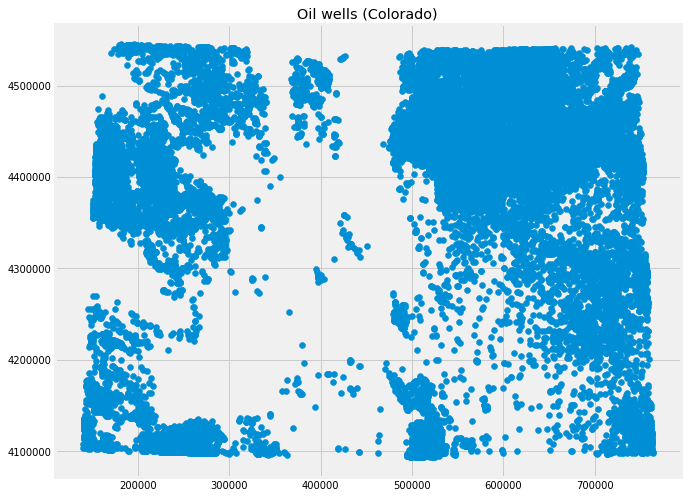

In [4]:
col_oil_gas.plot(figsize=(10, 20))
plt.title("Oil wells (Colorado)");

### Oil tank batteries data

In [5]:
# metadata: https://cogcc.state.co.us/documents/data/downloads/gis/metadata/Tank_Batteries_Metadata.html
# Tank Battery is a device used to store crude oil which is produced from a well.

col_tank_batteries = gpd.read_file("./TANK_BATTERIES_SHP")

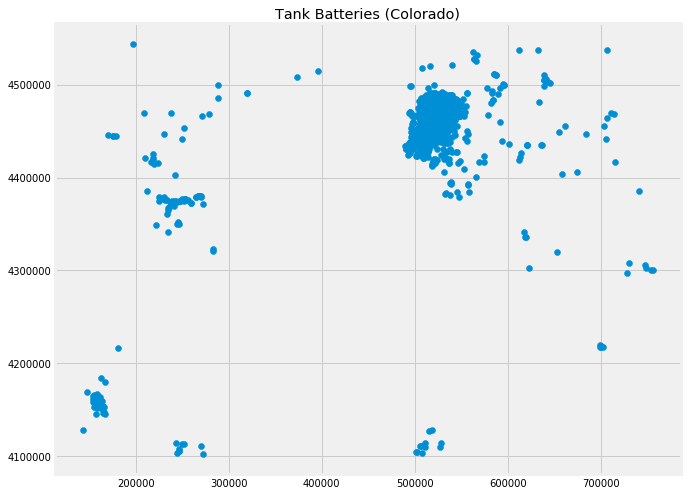

In [6]:
col_tank_batteries.plot(figsize=(10, 20))
plt.title("Tank Batteries (Colorado)");

### Oil pits data

In [7]:
# oil pits: https://cogcc.state.co.us/documents/data/downloads/gis/metadata/Pits_Metadata.html
col_pits = gpd.read_file("./PITS_SHP")

In [8]:
# col_pits.plot(figsize=(10, 20))

# plt.title("Pits (Colorado)");

#can see outliers outside of Colorado

### Colorado census blocks shape data

In [9]:
# Colorado census block shapes data: https://catalog.data.gov/dataset/tiger-line-shapefile-2019-2010-state-colorado-2010-census-block-state-based
col_blocks = gpd.read_file("./tl_2019_08_tabblock10/tl_2019_08_tabblock10.shp")

In [10]:
col_blocks.shape

(201062, 16)

In [11]:
col_blocks.head()[['geometry']].loc[0, :][0].bounds

(-104.92234, 39.689361, -104.91952, 39.692589)

In [12]:
# col_blocks.plot(figsize=(10, 20))
# plt.title("Colorado Block Level Borders");

### Plot all layers together

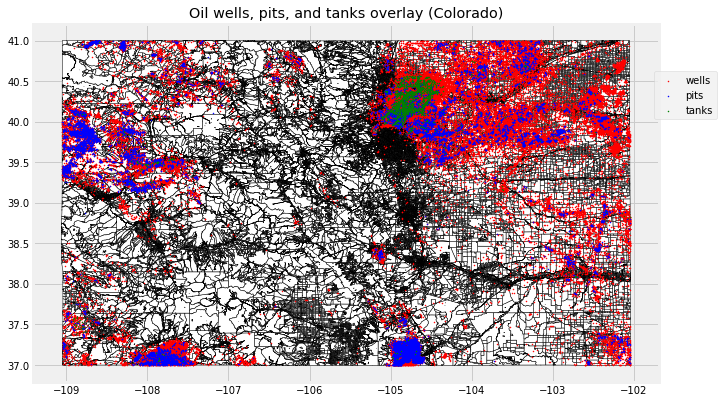

In [13]:
base = col_blocks.plot(color='white', edgecolor='black', figsize=(10, 20))

col_oil_gas = col_oil_gas.to_crs(col_blocks.crs)

#get rid of outlying points outside of Colorado
col_pits = col_pits[(col_pits['Latitude'] > 35) & (col_pits['Longitude'] < -100)] 

#need to make sure all are on the same crs (coordate reference system)
col_pits = col_pits.to_crs(col_blocks.crs)
col_tank_batteries = col_tank_batteries.to_crs(col_blocks.crs)

col_oil_gas.plot(ax=base, marker='o', color='red', markersize=1, label='wells')
col_pits.plot(ax=base, marker='o', color='blue', markersize=1, label='pits')
col_tank_batteries.plot(ax=base, marker='o', color='green', markersize=1, label='tanks')
plt.legend(loc="center right", bbox_to_anchor=(1.1, 0.8))
plt.title("Oil wells, pits, and tanks overlay (Colorado)")
plt.show();

## Filter out non-populated blocks <a id='filter_non_pop'></a>

In [14]:
#non populated block codes in Colorado BY GEOID to get unique codes!!

non_pop_blocks_geoid = []

In [15]:
#get all county codes in Colorado: https://simple.wikipedia.org/wiki/List_of_counties_in_Colorado
# 001 - 125 by odd nums

counties = list(map(str, np.arange(1, 127, 2)))
counties = list(map(lambda x: str.zfill(x, 3), counties))

In [16]:
#Get population data
#Using Decennial SF1 (Summary File 1) 2010 because it goes down to block level
# https://api.census.gov/data.html << find Decennial SF1 in 2010
#ACS5 has more recent population data until 2018, but only goes down to block group level
#Colorado is state code 08
#Have to use for loop over all counties because api doesn't let us iterate over all blocks at once 

for county_code in counties: 
    url = "https://api.census.gov/data/2010/dec/sf1?get=NAME,group(P1)&for=block:*&in=state:08%county:" + county_code
    r = requests.get(url)

    r.raise_for_status()
    
    data = r.json()

    block_df = pd.DataFrame(data)
    block_df.columns = block_df.iloc[0]
    block_df = block_df.iloc[1:]

    # P001001	Total	TOTAL POPULATION
    block_df['P001001'] = block_df['P001001'].apply(int)
    
    #what to do with margin of error in population counts? P001001ERR
    non_pop_blocks_geoid.extend(block_df[block_df['P001001'] == 0]['GEO_ID'].values.tolist())

In [17]:
#geoid's should all be unique
# 201,062 total census blocks in Colorado

pd.Series(non_pop_blocks_geoid).value_counts().sort_values()

1000000US080239726002630    1
1000000US080050067122010    1
1000000US081010032002336    1
1000000US081230010051029    1
1000000US080690017091196    1
                           ..
1000000US081230021034045    1
1000000US080690018082016    1
1000000US080759659001065    1
1000000US080130134013006    1
1000000US080319800001151    1
Length: 95332, dtype: int64

In [18]:
# should have 105730 populated blocks in Colorado 

201062 - 95332

105730

In [19]:
#Save file 

with open('path_to_file.json', 'w') as file:
    for item in non_pop_blocks_geoid: 
        line = json.dumps(item)
        file.write(line + '\n')

In [20]:
data_geoid_nonpop = []
with open('path_to_file.json', 'r') as file:
    for line in file: 
        data_item = json.loads(line)
        data_geoid_nonpop.append(data_item)

In [21]:
#get rid of first '1000000US' of strings 
data_geoid_nonpop = pd.Series(data_geoid_nonpop).apply(lambda x: x[9:])

In [22]:
col_blocks_copy = col_blocks.copy()

In [23]:
# Filter out blocks with no population
filter_col_blocks_pop = col_blocks_copy[~col_blocks_copy['GEOID10'].isin(data_geoid_nonpop)]

In [24]:
filter_col_blocks_pop.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYPE,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,08,031,005200,1010,080310052001010,Block 1010,G5040,U,23527,U,S,46625,0,+39.6907584,-104.9212054,"POLYGON ((-104.92234 39.68979, -104.92233 39.6..."
1,08,031,005200,3012,080310052003012,Block 3012,G5040,U,23527,U,S,17181,0,+39.6829812,-104.9217342,"POLYGON ((-104.92224 39.68374, -104.92224 39.6..."
2,08,031,005001,1009,080310050011009,Block 1009,G5040,U,23527,U,S,18812,0,+39.7020795,-104.9213633,"POLYGON ((-104.92164 39.70386, -104.92143 39.7..."
3,08,031,005001,1003,080310050011003,Block 1003,G5040,U,23527,U,S,20086,0,+39.7029551,-104.9158497,"POLYGON ((-104.91643 39.70241, -104.91643 39.7..."
4,08,031,001901,2017,080310019012017,Block 2017,G5040,U,23527,U,S,11437,0,+39.7329683,-105.0056579,"POLYGON ((-105.00615 39.73371, -105.00597 39.7..."


In [124]:
filter_col_blocks_pop.shape

(105730, 16)

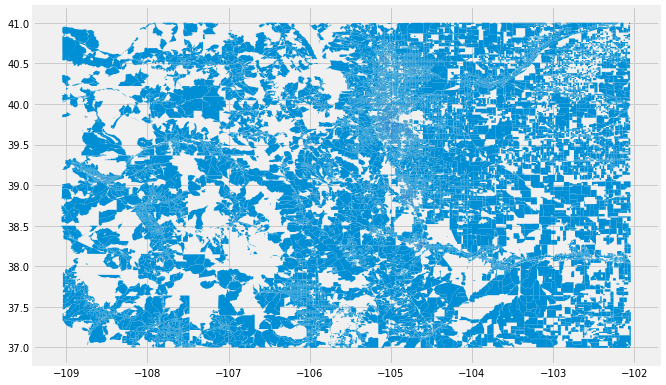

In [25]:
filter_col_blocks_pop.plot(figsize=(10, 20))

In [26]:
filter_col_blocks_pop_copy = filter_col_blocks_pop.copy()
col_blocks_buffered_df= filter_col_blocks_pop_copy.copy()

## Create buffers on populated census blocks <a id='buffer'></a>

According to fractracker.org at this [link](https://www.fractracker.org/2019/07/impact-of-a-2500-oil-and-gas-well-setback-in-california/), **2500 feet, or 0.762 km** seems to be the minimum buffer distance from oil fields to surrounding population in consideration of public health: 

"An established setback is therefore necessary to alleviate some of these health burdens carried by the most vulnerable Environmental Justice (EJ) communities. Health assessments by the Los Angeles County Department of Health and studies on ambient air quality near oil fields by Occidental College Researchers support the assumption that 2,500′ is the necessary distance to help alleviate the harsh conditions of degraded air quality. Living at a distance beyond 2,500′ from an oil and gas site does not mean you are not impacted by air and water contamination. Rather the concentrations of contaminants will be less harmful. In fact studies showed that health impacts increased with proximity to oil and gas, with associated impacts potentially experienced by communities living at distances up to 9.3 miles (Currie et al. 2017) and 10 miles (Whitworth et al. 2017)."

I'll then use 0.762km as the buffer distance around census blocks and then counting the number of oil facilities within the entire buffered block.

In [27]:
# calculating buffer distance 
# need buffer distance approximate number of degrees of longitude
# lat lon coords at Denver: 39.7392° N, 104.9903° W

# want to convert buffer distance of 0.762km to degrees longitude

# lat: 1 deg = 110.574km
# lon: 1 deg = 111.320*cos(latitude)km

#lat at Denver: 39.7392 deg >> 39.7392*pi/180 

#0.762km * (1 deg/ 111.320*cos(39.7392 converted into radians))
lat_radians = 39.7392 * np.pi/180
0.762/(111.32*np.cos(lat_radians))
#np.cos is in RADIANS

0.008901776731952719

In [28]:
#alt: convert 2000 feet >> 0.6096km

lat_radians = 39.7392 * np.pi/180
0.6096/(111.32*np.cos(lat_radians))

0.007121421385562175

In [29]:
# later will implement buffer considering lat/lon diff...
# buffer of 2000 ft for each block for now
col_blocks_buffered = filter_col_blocks_pop_copy.apply(lambda x: x.iloc[-1].buffer(0.007121421385562175), axis=1) #axis = 1 to apply to each row

In [30]:
#df with buffered blocks as geometry col
col_blocks_buffered_df['geometry'] = col_blocks_buffered 

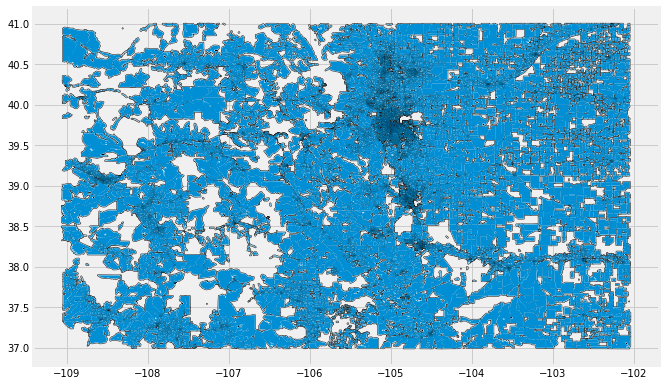

In [31]:
base = col_blocks_buffered_df.plot(color='white', edgecolor='black', figsize=(10, 20))

filter_col_blocks_pop_copy.plot(ax=base)

## Count the # of wells, pits, tanks within buffered blocks, partitioned by facility status <a id='count_totals'></a>

In [32]:
# counts oil facilities within buffered blocks

# fyi sjoin super slow (> 30 mins and lot of memory) when using > 0.01 
# Want multiple rows of the same block with different facility data, for a block with multiple wells in it
dfsjoin_oil = gpd.sjoin(col_blocks_buffered_df, col_oil_gas, op='intersects') #Spatial join Points to polygons
dfpivot_oil = pd.pivot_table(dfsjoin_oil,index='GEOID10',columns='fac_status',aggfunc={'fac_status':len}, fill_value=0)
dfpivot_oil.columns = dfpivot_oil.columns.droplevel()
dfpivot_oil['total'] = dfpivot_oil.sum(axis=1)
dfpivot_oil = dfpivot_oil.reset_index()
dfpivot_oil.head()

fac_status,GEOID10,AC,AL,CL,SU,total
0,080010083081000,0,0,1,0,1
1,080010083091019,0,0,1,0,1
2,080010083531002,1,2,2,0,5
3,080010083531004,11,4,7,0,22
4,080010083531006,2,0,1,0,3


In [125]:
dfpivot_oil.shape

(19843, 6)

In [33]:
# counts pits within buffered blocks

dfsjoin_pits = gpd.sjoin(col_blocks_buffered_df, col_pits, op='intersects') #Spatial join Points to polygons
dfpivot_pits = pd.pivot_table(dfsjoin_pits,index='GEOID10',columns='Facil_Stat',aggfunc={'Facil_Stat':len}, fill_value=0)
dfpivot_pits.columns = dfpivot_pits.columns.droplevel()
dfpivot_pits['total'] = dfpivot_pits.sum(axis=1)
dfpivot_pits = dfpivot_pits.reset_index()
dfpivot_pits.head()

Facil_Stat,GEOID10,AC,AL,CL,UN,total
0,080010083532027,0,0,2,0,2
1,080010084011003,0,0,2,0,2
2,080010084011007,0,0,6,0,6
3,080010084011008,0,0,5,0,5
4,080010084011009,0,0,15,0,15


In [34]:
# counts tanks within buffered blocks

dfsjoin_tanks = gpd.sjoin(col_blocks_buffered_df, col_tank_batteries, op='intersects') #Spatial join Points to polygons
dfpivot_tanks = pd.pivot_table(dfsjoin_tanks,index='GEOID10',columns='fac_status',aggfunc={'fac_status':len}, fill_value=0)
dfpivot_tanks.columns = dfpivot_tanks.columns.droplevel()
dfpivot_tanks['total'] = dfpivot_tanks.sum(axis=1)
dfpivot_tanks = dfpivot_tanks.reset_index()
dfpivot_tanks.head()

fac_status,GEOID10,AC,AL,CL,PR,SI,XX,total
0,080010084011003,1,0,1,0,0,0,2
1,080010084011007,1,0,0,0,0,0,1
2,080010084011008,1,0,0,0,0,0,1
3,080010084011009,1,0,0,0,0,0,1
4,080010084011010,3,0,0,0,0,0,3


## Create oil score per buffered block (equal weights for all tanks, pits, wells, status codes) <a id='block_oil_score'></a>

In [71]:
#sum total counts for all oil facilities, tanks, pits

merged_all = dfpivot_oil.merge(dfpivot_pits, on="GEOID10", how='outer').merge(dfpivot_tanks, on='GEOID10', how='outer')

merged_all_counts = merged_all.set_index("GEOID10")[['total_x', 'total_y', 'total']].sum(axis=1).reset_index()
merged_all_counts = merged_all_counts.rename(columns={0: 'oil_total'})

In [182]:
merged_all_counts.sort_values('oil_total', ascending=False).head()

,GEOID10,oil_total
19111,081230025022053,1325.0
18879,081230025011484,1307.0
19108,081230025022047,995.0
9860,080710003002238,889.0
9845,080710003002181,551.0


In [74]:
merged_all_counts.shape

(19953, 2)

In [132]:
# add geometry column (from non-buffered blocks), add FIPS_tract_id, turn into geodataframe

merged_all_counts_geo = merged_all_counts.merge(col_blocks, on="GEOID10", how="inner")
merged_all_counts_geo['FIPS_tract_id'] = merged_all_counts_geo['GEOID10'].str[:11]
merged_all_counts_geo = gpd.GeoDataFrame(merged_all_counts_geo, geometry='geometry')
merged_all_counts_geo.head()

,GEOID10,oil_total,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,NAME10,MTFCC10,UR10,UACE10,UATYPE,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,FIPS_tract_id
0,080010083081000,1.0,08,001,008308,1000,Block 1000,G5040,U,23527,U,S,228843,0,+39.7724768,-104.8177083,"POLYGON ((-104.82823 39.77317, -104.82749 39.7...",08001008308
1,080010083091019,1.0,08,001,008309,1019,Block 1019,G5040,U,23527,U,S,952289,0,+39.7663113,-104.7827326,"POLYGON ((-104.79083 39.76899, -104.79080 39.7...",08001008309
2,080010083531002,5.0,08,001,008353,1002,Block 1002,G5040,R,None,None,S,1187260,1040,+39.7881957,-104.6281513,"POLYGON ((-104.63574 39.79075, -104.63566 39.7...",08001008353
3,080010083531004,22.0,08,001,008353,1004,Block 1004,G5040,R,None,None,S,21317699,33161,+39.7785643,-104.6847111,"POLYGON ((-104.71631 39.77767, -104.71628 39.7...",08001008353
4,080010083531006,3.0,08,001,008353,1006,Block 1006,G5040,R,None,None,S,1952672,0,+39.7601219,-104.7064338,"POLYGON ((-104.71588 39.75718, -104.71586 39.7...",08001008353


In [133]:
merged_all_counts_geo.shape

(19953, 18)

In [134]:
merged_all_counts_geo['Block_Area'] = merged_all_counts_geo.area

In [135]:
merged_all_counts_geo.head()

,GEOID10,oil_total,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,NAME10,MTFCC10,UR10,UACE10,UATYPE,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,FIPS_tract_id,Block_Area
0,080010083081000,1.0,08,001,008308,1000,Block 1000,G5040,U,23527,U,S,228843,0,+39.7724768,-104.8177083,"POLYGON ((-104.82823 39.77317, -104.82749 39.7...",08001008308,0.000024
1,080010083091019,1.0,08,001,008309,1019,Block 1019,G5040,U,23527,U,S,952289,0,+39.7663113,-104.7827326,"POLYGON ((-104.79083 39.76899, -104.79080 39.7...",08001008309,0.000100
2,080010083531002,5.0,08,001,008353,1002,Block 1002,G5040,R,None,None,S,1187260,1040,+39.7881957,-104.6281513,"POLYGON ((-104.63574 39.79075, -104.63566 39.7...",08001008353,0.000125
3,080010083531004,22.0,08,001,008353,1004,Block 1004,G5040,R,None,None,S,21317699,33161,+39.7785643,-104.6847111,"POLYGON ((-104.71631 39.77767, -104.71628 39.7...",08001008353,0.002245
4,080010083531006,3.0,08,001,008353,1006,Block 1006,G5040,R,None,None,S,1952672,0,+39.7601219,-104.7064338,"POLYGON ((-104.71588 39.75718, -104.71586 39.7...",08001008353,0.000205


In [136]:
merged_all_counts_geo.columns

Index(['GEOID10', 'oil_total', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10',
       'BLOCKCE10', 'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYPE',
       'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10',
       'geometry', 'FIPS_tract_id', 'Block_Area'],
      dtype='object')

## Aggregate scores from block level to tracts <a id='tract_oil_score'></a>

From Sid's work on blocks to tracts:

In [137]:
col_blocks_copy = col_blocks.copy()

In [146]:
# add shape area and FIPS_tract_id

col_blocks_copy['All_Blocks_Area'] = col_blocks_copy.area
col_blocks_copy['FIPS_tract_id'] = col_blocks_copy['GEOID10'].str[:11]

In [147]:
col_blocks.columns

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10', 'GEOID10',
       'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYPE', 'FUNCSTAT10',
       'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry'],
      dtype='object')

In [148]:
col_blocks.shape

(201062, 16)

In [155]:
# Find total area of each tract by summing corresponding blocks (which all have the same FIPS tract id)
# Using the non-buffered all blocks data
df_tracts = col_blocks_copy[['STATEFP10','FIPS_tract_id','All_Blocks_Area']].groupby('FIPS_tract_id',as_index=False).sum()
df_tracts = df_tracts.rename(columns={"All_Blocks_Area":"Tract_Area"})

In [159]:
df_tracts.head()

,FIPS_tract_id,Tract_Area
0,08001007801,0.000067
1,08001007802,0.000067
2,08001007900,0.000172
3,08001008000,0.000206
4,08001008100,0.000284


In [157]:
# 1249 census tracts in CO
df_tracts.shape

(1249, 2)

In [165]:
# Create new dataframe that for each block group row, specifies total tract area (for the tract in which the block group is located)
# We are only selecting the 5 indicators and shape information when merging.

df_with_areas = pd.merge(merged_all_counts_geo[['GEOID10','STATEFP10','FIPS_tract_id','oil_total','Block_Area','geometry']], df_tracts[['FIPS_tract_id','Tract_Area']], on='FIPS_tract_id')
df_with_areas.head()

,GEOID10,STATEFP10,FIPS_tract_id,oil_total,Block_Area,geometry,Tract_Area
0,080010083081000,08,08001008308,1.0,0.000024,"POLYGON ((-104.82823 39.77317, -104.82749 39.7...",0.000463
1,080010083091019,08,08001008309,1.0,0.000100,"POLYGON ((-104.79083 39.76899, -104.79080 39.7...",0.001278
2,080010083531002,08,08001008353,5.0,0.000125,"POLYGON ((-104.63574 39.79075, -104.63566 39.7...",0.011852
3,080010083531004,08,08001008353,22.0,0.002245,"POLYGON ((-104.71631 39.77767, -104.71628 39.7...",0.011852
4,080010083531006,08,08001008353,3.0,0.000205,"POLYGON ((-104.71588 39.75718, -104.71586 39.7...",0.011852


In [166]:
df_with_areas.shape

(19953, 7)

In [167]:
# Create a new column that gives proportion of tract that each block group contributes
df_with_areas['Tract_Proportion'] = df_with_areas['Block_Area'] / df_with_areas['Tract_Area']
df_with_areas.head()

,GEOID10,STATEFP10,FIPS_tract_id,oil_total,Block_Area,geometry,Tract_Area,Tract_Proportion
0,080010083081000,08,08001008308,1.0,0.000024,"POLYGON ((-104.82823 39.77317, -104.82749 39.7...",0.000463,0.052003
1,080010083091019,08,08001008309,1.0,0.000100,"POLYGON ((-104.79083 39.76899, -104.79080 39.7...",0.001278,0.078309
2,080010083531002,08,08001008353,5.0,0.000125,"POLYGON ((-104.63574 39.79075, -104.63566 39.7...",0.011852,0.010542
3,080010083531004,08,08001008353,22.0,0.002245,"POLYGON ((-104.71631 39.77767, -104.71628 39.7...",0.011852,0.189389
4,080010083531006,08,08001008353,3.0,0.000205,"POLYGON ((-104.71588 39.75718, -104.71586 39.7...",0.011852,0.017316


In [168]:
# Create new column with how much each block group contributes to the indicator
df_with_areas['oil_proportion'] = df_with_areas['oil_total'] * df_with_areas['Tract_Proportion']

df_with_areas.drop(columns={'oil_total'}, inplace=True)

df_with_areas.head()

,GEOID10,STATEFP10,FIPS_tract_id,Block_Area,geometry,Tract_Area,Tract_Proportion,oil_proportion
0,080010083081000,08,08001008308,0.000024,"POLYGON ((-104.82823 39.77317, -104.82749 39.7...",0.000463,0.052003,0.052003
1,080010083091019,08,08001008309,0.000100,"POLYGON ((-104.79083 39.76899, -104.79080 39.7...",0.001278,0.078309,0.078309
2,080010083531002,08,08001008353,0.000125,"POLYGON ((-104.63574 39.79075, -104.63566 39.7...",0.011852,0.010542,0.052711
3,080010083531004,08,08001008353,0.002245,"POLYGON ((-104.71631 39.77767, -104.71628 39.7...",0.011852,0.189389,4.166561
4,080010083531006,08,08001008353,0.000205,"POLYGON ((-104.71588 39.75718, -104.71586 39.7...",0.011852,0.017316,0.051949


In [185]:
df_with_areas.shape

(19953, 8)

In [237]:
# Create table with tract-average values for every tract
# Sums the proportions of all the block groups of a tract to create a total weighted average for each tract
tracts_w_oil = df_with_areas[['STATEFP10','FIPS_tract_id', 'oil_proportion']].groupby('FIPS_tract_id').sum()
tracts_w_oil = tracts_w_oil.rename(columns={'oil_proportion':'oil_score'})

In [238]:
tracts_w_oil.head()

,oil_score
FIPS_tract_id,
08001008308,0.052003
08001008309,0.078309
08001008353,4.793061
08001008401,27.517479
08001008402,51.397751


In [239]:
# 442/1249 >> around 0.35 of CO census tracts 
# btw census tracts are apparently:  
# "designed to be relatively homogeneous units with respect to population characteristics, economic status, and living conditions" and "average about 4,000 inhabitants"
tracts_w_oil.shape

(442, 1)

In [240]:
# Calculate percentiles
tracts_w_oil['oil_rank'] = tracts_w_oil.rank(method='average', na_option='keep', pct=True)*100

In [241]:
tracts_w_oil.head()

,oil_score,oil_rank
FIPS_tract_id,,
08001008308,0.052003,4.977376
08001008309,0.078309,8.597285
08001008353,4.793061,66.289593
08001008401,27.517479,87.556561
08001008402,51.397751,95.248869


In [242]:
tracts_w_oil.shape

(442, 2)

In [243]:
tracts_w_oil = tracts_w_oil.reset_index()

In [244]:
tracts_w_oil = tracts_w_oil.astype({'FIPS_tract_id': 'str'})
tracts_w_oil = tracts_w_oil.set_index("FIPS_tract_id")

In [245]:
tracts_w_oil.head()

,oil_score,oil_rank
FIPS_tract_id,,
08001008308,0.052003,4.977376
08001008309,0.078309,8.597285
08001008353,4.793061,66.289593
08001008401,27.517479,87.556561
08001008402,51.397751,95.248869


In [316]:
# fill in score and rank of 0 for tracts without any overlap with oil

oil_df_area = tracts_w_oil.merge(df_tracts, on='FIPS_tract_id', how='right').fillna(0)
oil_df = oil_df_area.drop(columns = 'Tract_Area')

In [317]:
oil_df.head()

,FIPS_tract_id,oil_score,oil_rank
0,08001008308,0.052003,4.977376
1,08001008309,0.078309,8.597285
2,08001008353,4.793061,66.289593
3,08001008401,27.517479,87.556561
4,08001008402,51.397751,95.248869


In [318]:
oil_df.shape

(1249, 3)

## Analysis <a id='analysis'></a>

### Merge final oil dataframe with combined indicators data

In [471]:
#create another metric: oil score/tract area to see if that accounts for some tracts being much larger than others

oil_df_area['oil_score_area'] = oil_df_area['oil_score']/oil_df_area['Tract_Area']

In [472]:
oil_df_area.head()

,FIPS_tract_id,oil_score,oil_rank,Tract_Area,oil_score_area
0,08001008308,0.052003,4.977376,0.000463,112.416476
1,08001008309,0.078309,8.597285,0.001278,61.262222
2,08001008353,4.793061,66.289593,0.011852,404.410160
3,08001008401,27.517479,87.556561,0.052883,520.343521
4,08001008402,51.397751,95.248869,0.184549,278.505310


In [473]:
oil_df_area.shape

(1249, 5)

In [474]:
# read combined indicators/scores data
# >> switch to using the db 

colorado_final = pd.read_csv("./Colorado_final.csv")

In [475]:
colorado_final.head()

,Unnamed: 0,NAME,state,FIPS_tract_id,lead_score,lead_rank,total_pop,poverty_score,poverty_rank,edu_score,...,HD_rank,demographic_score,exposure_score,effects_score,sensitive_score,Pollution_Burden,Pop_Char,FinalScore,missing_values,Final_Rank
0,0,"Census Tract 9646, Delta County, Colorado",8,8029964600,0.234207,78.866397,3527.0,34.902183,72.639225,4.4,...,92.298387,46.323682,7.289137,27.526682,63.625107,16.464698,54.974395,8.086725,0,6.416667
1,1,"Census Tract 9647, Delta County, Colorado",8,8029964700,0.119621,61.700405,3815.0,35.989515,73.688458,10.2,...,91.411290,52.075859,9.818064,22.780433,58.973025,17.411542,55.524442,8.637337,0,7.416667
2,2,"Census Tract 9649, Delta County, Colorado",8,8029964900,0.080954,52.388664,5683.0,48.161182,88.539144,6.9,...,93.508065,66.229316,15.850643,26.138261,55.463863,24.563397,60.846590,13.353131,0,17.250000
3,3,"Census Tract 9648, Delta County, Colorado",8,8029964800,0.147783,66.720648,4000.0,35.550000,73.284907,17.9,...,88.991935,69.436468,16.695108,42.247252,53.042387,30.777525,61.239427,16.839271,0,25.166667
4,4,"Census Tract 9650, Delta County, Colorado",8,8029965000,0.163839,68.744939,4707.0,27.979605,58.111380,5.3,...,76.048387,41.414737,6.997643,25.358275,38.656541,15.450402,40.035639,5.526434,0,1.916667


In [476]:
colorado_final['FIPS_tract_id'] =  '0' + colorado_final['FIPS_tract_id'].astype(str)

In [661]:
# merge with combined indicators notebook

co_final_oil = oil_df_area.merge(colorado_final, on='FIPS_tract_id', how='inner')

In [662]:
co_final_oil.head()

,FIPS_tract_id,oil_score,oil_rank,Tract_Area,oil_score_area,Unnamed: 0,NAME,state,lead_score,lead_rank,...,HD_rank,demographic_score,exposure_score,effects_score,sensitive_score,Pollution_Burden,Pop_Char,FinalScore,missing_values,Final_Rank
0,08001008308,0.052003,4.977376,0.000463,112.416476,1171,"Census Tract 83.08, Adams County, Colorado",8,0.062083,43.562753,...,54.354839,91.144876,77.210568,63.748579,71.499338,98.460095,81.322107,71.536441,0,98.416667
1,08001008309,0.078309,8.597285,0.001278,61.262222,1195,"Census Tract 83.09, Adams County, Colorado",8,0.048730,35.546559,...,44.072581,91.333349,65.337627,63.922763,71.142752,86.645214,81.238050,62.887239,2,94.250000
2,08001008353,4.793061,66.289593,0.011852,404.410160,1196,"Census Tract 83.53, Adams County, Colorado",8,0.033126,26.072874,...,29.677419,68.940312,54.133729,58.377105,68.115118,73.592764,68.527715,45.056745,0,76.583333
3,08001008401,27.517479,87.556561,0.052883,520.343521,780,"Census Tract 84.01, Adams County, Colorado",8,0.089650,55.303644,...,73.185484,50.793612,29.950249,35.544316,56.432838,41.798354,53.613225,20.021175,0,32.750000
4,08001008402,51.397751,95.248869,0.184549,278.505310,1187,"Census Tract 84.02, Adams County, Colorado",8,0.079539,51.578947,...,81.330645,30.949075,19.343661,34.431082,73.056871,30.820688,52.002973,14.319537,0,19.500000


In [663]:
co_final_oil.shape

(1249, 56)

### Exploratory data analysis btw oil and other indicators/final scores

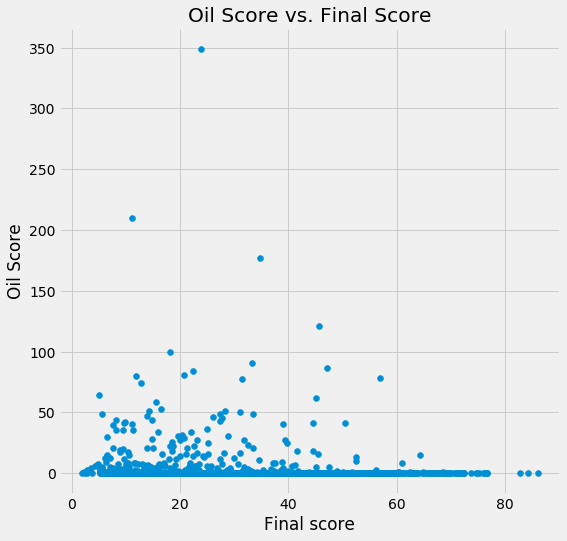

In [664]:
plt.figure(figsize=(8, 8))
plt.xlabel("Final score")
plt.ylabel("Oil Score")
plt.scatter(co_final_oil['FinalScore'], co_final_oil['oil_score'])
plt.title("Oil Score vs. Final Score");

In [665]:
# R^2 (coefficient of determination) regression score
co_score = co_final_oil[['FinalScore', 'oil_score']].dropna()
regr = linear_model.LinearRegression()
regr.fit(co_score[['FinalScore']], co_score[['oil_score']])
regr.score(co_score[['FinalScore']], co_score[['oil_score']])

0.008654701465098946

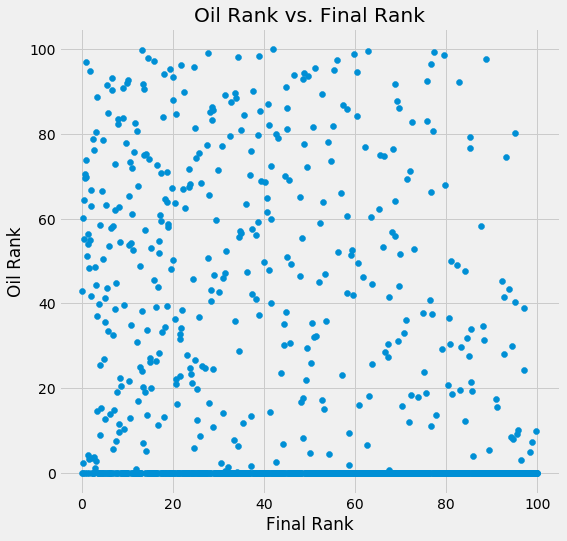

In [666]:
plt.figure(figsize=(8, 8))
# plt.ylim(0, 250)
plt.xlabel("Final Rank")
plt.ylabel("Oil Rank")
plt.scatter(co_final_oil['Final_Rank'], co_final_oil['oil_rank'])
plt.title("Oil Rank vs. Final Rank");

In [667]:
co_rank = co_final_oil[['Final_Rank', 'oil_rank']].dropna()
regr = linear_model.LinearRegression()
regr.fit(co_rank[['Final_Rank']], co_rank[['oil_rank']])
regr.score(co_rank[['Final_Rank']], co_rank[['oil_rank']])

0.08032964652366081

In [486]:
co_final_oil.columns

Index(['FIPS_tract_id', 'oil_score', 'oil_rank', 'Tract_Area',
       'oil_score_area', 'Unnamed: 0', 'NAME', 'state', 'lead_score',
       'lead_rank', 'total_pop', 'poverty_score', 'poverty_rank', 'edu_score',
       'edu_rank', 'lin_score', 'lin_rank', 'unemploy_score', 'unemploy_rank',
       'nonwhitePerc', 'nonwhite_rank', 'HouseBurden_score',
       'HouseBurden_rank', 'ozone_score', 'ozone_rank', 'diesel_score',
       'diesel_rank', 'toxics_score', 'toxics_rank', 'PM25_score', 'PM25_rank',
       'Avg_PTRAF', 'Avg_PTSDF', 'Avg_PRMP', 'Avg_PWDIS', 'Avg_PNPL',
       'PTRAF_rank', 'PTSDF_rank', 'PRMP_rank', 'PWDIS_rank', 'PNPL_rank',
       'asthma_score', 'asthma_rank', 'LB_score', 'LB_rank', 'HD_score',
       'HD_rank', 'demographic_score', 'exposure_score', 'effects_score',
       'sensitive_score', 'Pollution_Burden', 'Pop_Char', 'FinalScore',
       'missing_values', 'Final_Rank'],
      dtype='object')

In [668]:
co_nonwhite = co_final_oil[['nonwhitePerc', 'oil_rank']].dropna()

regr = linear_model.LinearRegression()
regr.fit(co_nonwhite[['nonwhitePerc']], co_nonwhite[['oil_rank']])
regr.score(co_nonwhite[['nonwhitePerc']], co_nonwhite[['oil_rank']])

0.016374546892649167

In [670]:
co_nonwhite_asthma = co_final_oil[['nonwhitePerc', 'oil_rank', 'asthma_score']].dropna()

regr = linear_model.LinearRegression()
regr.fit(co_nonwhite_asthma[['oil_rank', 'asthma_score']], co_nonwhite_asthma[['nonwhitePerc']])
regr.score(co_nonwhite_asthma[['oil_rank', 'asthma_score']], co_nonwhite_asthma[['nonwhitePerc']])

0.2491854231102768

In [671]:
co_nonwhite_poverty = co_final_oil[['nonwhitePerc', 'oil_rank', 'poverty_score']].dropna()

regr = linear_model.LinearRegression()
regr.fit(co_nonwhite_poverty[['oil_rank', 'poverty_score']], co_nonwhite_poverty[['nonwhitePerc']])
regr.score(co_nonwhite_poverty[['oil_rank', 'poverty_score']], co_nonwhite_poverty[['nonwhitePerc']])

0.4002181321077568

#### Using oil_score_area

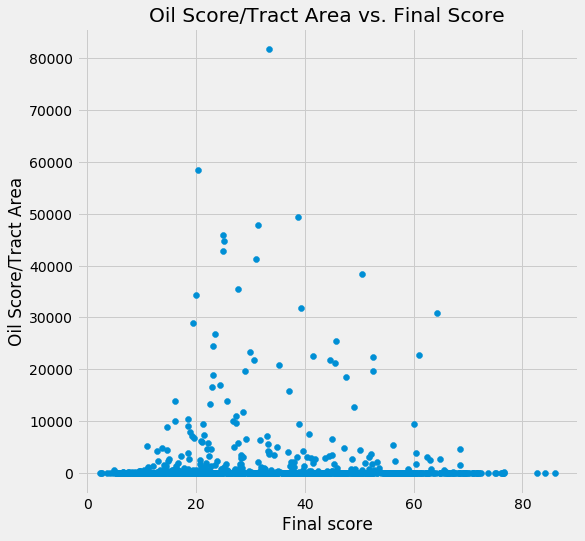

In [495]:
plt.figure(figsize=(8, 8))
plt.xlabel("Final score")
plt.ylabel("Oil Score/Tract Area")
plt.scatter(co_final_oil['FinalScore'], co_final_oil['oil_score_area'])
plt.title("Oil Score/Tract Area vs. Final Score");

In [672]:
co_score_area = co_final_oil[['oil_score_area', 'FinalScore']].dropna()

# R^2 (coefficient of determination) regression score
regr = linear_model.LinearRegression()
regr.fit(co_score_area[['oil_score_area']], co_score_area[['FinalScore']])
regr.score(co_score_area[['oil_score_area']], co_score_area[['FinalScore']])

2.7773674558417838e-05

#### Weld and Garfield Counties

In [673]:
co_final_oil.columns

Index(['FIPS_tract_id', 'oil_score', 'oil_rank', 'Tract_Area',
       'oil_score_area', 'Unnamed: 0', 'NAME', 'state', 'lead_score',
       'lead_rank', 'total_pop', 'poverty_score', 'poverty_rank', 'edu_score',
       'edu_rank', 'lin_score', 'lin_rank', 'unemploy_score', 'unemploy_rank',
       'nonwhitePerc', 'nonwhite_rank', 'HouseBurden_score',
       'HouseBurden_rank', 'ozone_score', 'ozone_rank', 'diesel_score',
       'diesel_rank', 'toxics_score', 'toxics_rank', 'PM25_score', 'PM25_rank',
       'Avg_PTRAF', 'Avg_PTSDF', 'Avg_PRMP', 'Avg_PWDIS', 'Avg_PNPL',
       'PTRAF_rank', 'PTSDF_rank', 'PRMP_rank', 'PWDIS_rank', 'PNPL_rank',
       'asthma_score', 'asthma_rank', 'LB_score', 'LB_rank', 'HD_score',
       'HD_rank', 'demographic_score', 'exposure_score', 'effects_score',
       'sensitive_score', 'Pollution_Burden', 'Pop_Char', 'FinalScore',
       'missing_values', 'Final_Rank'],
      dtype='object')

In [674]:
co_final_oil['county_codes'] = co_final_oil['FIPS_tract_id'].str[:5]

In [675]:
# Weld County code: 08123
# Garfield County code: 08045

weld_garfield = co_final_oil[(co_final_oil['county_codes']=='08123') | (co_final_oil['county_codes']=='08045')]

In [678]:
weld_garfield.head()

,FIPS_tract_id,oil_score,oil_rank,Tract_Area,oil_score_area,Unnamed: 0,NAME,state,lead_score,lead_rank,...,demographic_score,exposure_score,effects_score,sensitive_score,Pollution_Burden,Pop_Char,FinalScore,missing_values,Final_Rank,county_codes
204,08045951600,0.433909,33.257919,0.157183,2.760539,394,"Census Tract 9516, Garfield County, Colorado",8,0.093473,56.356275,...,72.512596,20.406793,34.185587,24.756111,31.801988,48.634353,13.818340,0,17.750000,08045
205,08045951802,0.718387,41.176471,0.038748,18.539790,396,"Census Tract 9518.02, Garfield County, Colorado",8,0.031421,25.344130,...,49.238474,14.785003,19.832637,28.382937,21.395882,38.810706,7.418911,0,5.166667,08045
206,08045951803,0.182824,16.968326,0.009753,18.744798,682,"Census Tract 9518.03, Garfield County, Colorado",8,0.096263,56.599190,...,61.234659,14.955898,26.387893,39.096777,23.751862,50.165718,10.645428,0,12.333333,08045
207,08045951804,0.462000,34.389140,0.009912,46.611318,683,"Census Tract 9518.04, Garfield County, Colorado",8,0.050086,36.437247,...,74.122995,15.906564,24.517233,55.698549,24.078975,64.910772,13.964109,0,18.416667,08045
208,08045951901,40.363498,91.628959,0.038792,1040.517316,684,"Census Tract 9519.01, Garfield County, Colorado",8,0.086227,54.008097,...,63.290326,15.818198,23.659906,42.419197,23.704833,52.854761,11.193850,0,13.416667,08045


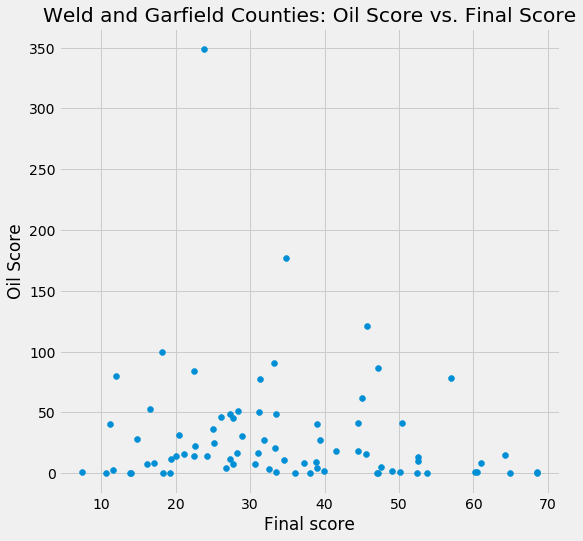

In [679]:
plt.figure(figsize=(8, 8))
plt.xlabel("Final score")
plt.ylabel("Oil Score")
plt.scatter(weld_garfield['FinalScore'], weld_garfield['oil_score'])
plt.title("Weld and Garfield Counties: Oil Score vs. Final Score");

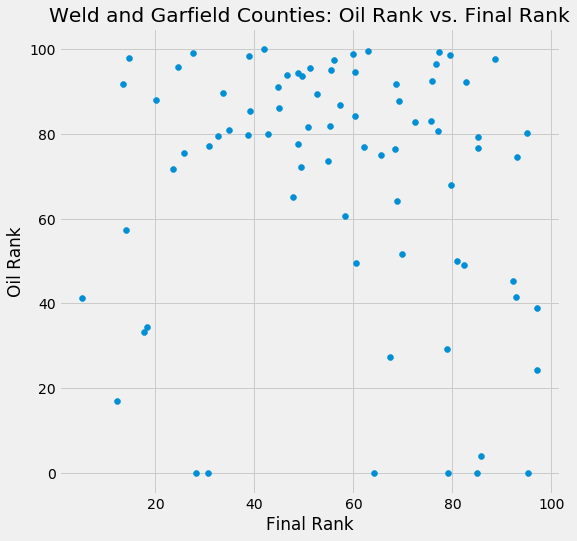

In [680]:
plt.figure(figsize=(8, 8))
plt.xlabel("Final Rank")
plt.ylabel("Oil Rank")
plt.scatter(weld_garfield['Final_Rank'], weld_garfield['oil_rank'])
plt.title("Weld and Garfield Counties: Oil Rank vs. Final Rank");

In [681]:


regr = linear_model.LinearRegression()
regr.fit(weld_garfield[['oil_rank']], weld_garfield[['Final_Rank']])
regr.score(weld_garfield[['oil_rank']], weld_garfield[['Final_Rank']])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [509]:
regr = linear_model.LinearRegression()
regr.fit(weld_garfield[['oil_score']], weld_garfield[['FinalScore']])
regr.score(weld_garfield[['oil_score']], weld_garfield[['FinalScore']])

0.02060070939311065

In [510]:
regr = linear_model.LinearRegression()
regr.fit(weld_garfield[['asthma_score']], weld_garfield[['nonwhitePerc']])
regr.score(weld_garfield[['asthma_score']], weld_garfield[['nonwhitePerc']])

0.27338191823888236

In [511]:
regr = linear_model.LinearRegression()
regr.fit(weld_garfield[['oil_rank', 'asthma_score']], weld_garfield[['nonwhitePerc']])
regr.score(weld_garfield[['oil_rank', 'asthma_score']], weld_garfield[['nonwhitePerc']])

0.2887362781324667

In [512]:
regr = linear_model.LinearRegression()
regr.fit(weld_garfield[['oil_score']], weld_garfield[['asthma_score']])
regr.score(weld_garfield[['oil_score']], weld_garfield[['asthma_score']])

0.07683670404173426

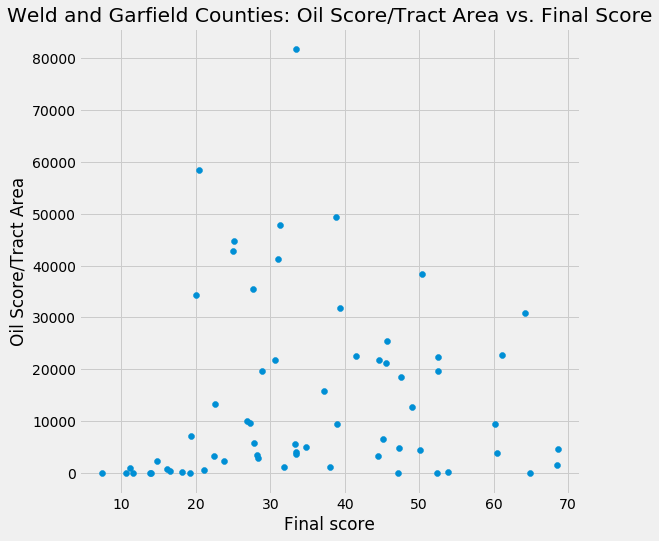

In [513]:
plt.figure(figsize=(8, 8))
plt.xlabel("Final score")
plt.ylabel("Oil Score/Tract Area")
plt.scatter(weld_garfield['FinalScore'], weld_garfield['oil_score_area'])
plt.title("Weld and Garfield Counties: Oil Score/Tract Area vs. Final Score");

In [515]:
# R^2 (coefficient of determination) regression score
regr = linear_model.LinearRegression()
regr.fit(weld_garfield[['oil_score_area']], weld_garfield[['FinalScore']])
regr.score(weld_garfield[['oil_score_area']], weld_garfield[['FinalScore']])

0.004691214158485391

In [517]:
# R^2 (coefficient of determination) regression score
regr = linear_model.LinearRegression()
regr.fit(weld_garfield[['oil_score_area']], weld_garfield[['demographic_score']])
regr.score(weld_garfield[['oil_score_area']], weld_garfield[['demographic_score']])

0.040084516962720085

In [521]:
# R^2 (coefficient of determination) regression score
regr = linear_model.LinearRegression()
regr.fit(weld_garfield[['oil_score_area', 'asthma_score']], weld_garfield[['nonwhitePerc']])
regr.score(weld_garfield[['oil_score_area', 'asthma_score']], weld_garfield[['nonwhitePerc']])

0.2752170237182242

#### Permitted, not drilled facilities

In [524]:
permits = gpd.read_file("./PERMITS_SHP")

In [526]:
permits.head()

,API,API_County,API_Seq,API_Label,Operat_Num,Operator,Well_Num,Well_Name,Well_Title,Ground_Ele,...,Section,Township,Range,Meridian,Latitude,Longitude,Utm_X,Utm_Y,Prop_Depth,geometry
0,12350431,123,50431,05-123-50431,10575,8 NORTH LLC,10S-20-10N,Brandstein,10S-20-10N Brandstein,5108.0,...,10,9N,60W,6,40.768678,-104.073752,578171,4513491,17001,POINT (578171.000 4513491.000)
1,12350430,123,50430,05-123-50430,10575,8 NORTH LLC,10S-20-11C,Brandstein,10S-20-11C Brandstein,5104.0,...,10,9N,60W,6,40.768678,-104.074056,578145,4513491,17229,POINT (578145.000 4513491.000)
2,12350432,123,50432,05-123-50432,10575,8 NORTH LLC,10S-20-12N,Brandstein,10S-20-12N Brandstein,5109.0,...,10,9N,60W,6,40.768678,-104.073652,578180,4513491,17100,POINT (578180.000 4513491.000)
3,12350433,123,50433,05-123-50433,10575,8 NORTH LLC,10S-20-7N,Brandstein,10S-20-7N Brandstein,5105.0,...,10,9N,60W,6,40.768678,-104.073955,578154,4513491,17169,POINT (578154.000 4513491.000)
4,12350435,123,50435,05-123-50435,10575,8 NORTH LLC,10S-20-8C,Brandstein,10S-20-8C Brandstein,5103.0,...,10,9N,60W,6,40.768678,-104.074157,578137,4513491,17202,POINT (578137.000 4513491.000)


In [527]:
permits.shape

(3842, 34)

In [528]:
permits.columns

Index(['API', 'API_County', 'API_Seq', 'API_Label', 'Operat_Num', 'Operator',
       'Well_Num', 'Well_Name', 'Well_Title', 'Ground_Ele', 'Perm_Type',
       'Perm_Appr', 'Perm_Exp', 'Field_Code', 'Field_Name', 'Facil_Id',
       'Facil_Type', 'Facil_Stat', 'Loc_Id', 'Dist_N_S', 'Dir_N_S', 'Dist_E_W',
       'Dir_E_W', 'Qtr_Qtr', 'Section', 'Township', 'Range', 'Meridian',
       'Latitude', 'Longitude', 'Utm_X', 'Utm_Y', 'Prop_Depth', 'geometry'],
      dtype='object')

In [533]:
permits['Perm_Exp'].sort_values().head()

3823    2020-07-02
3484    2020-07-02
956     2020-07-07
841     2020-07-07
846     2020-07-07
Name: Perm_Exp, dtype: object

In [537]:
# Permit Type (DE = Deepen; DR = Drill; RC = Recomplete ; RE = Reenter)

permits['Perm_Type'].value_counts()

DR    3837
RC       3
DE       1
RE       1
Name: Perm_Type, dtype: int64

In [541]:
# APPROVED PERMIT TO DRILL WELL; NOT YET REPORTED AS SPUD; INCLUDES EXPIRED PERMITS

permits['Facil_Stat'].value_counts()

XX    3842
Name: Facil_Stat, dtype: int64

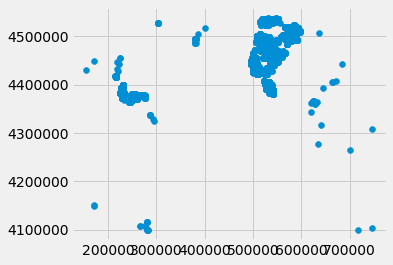

In [542]:
permits.plot()

In [551]:
permits = permits.to_crs(col_blocks_buffered_df.crs)

permits_oil = gpd.sjoin(col_blocks_buffered_df, permits, op='intersects') #Spatial join Points to polygons

In [553]:
permits_oil.columns

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10', 'GEOID10',
       'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYPE', 'FUNCSTAT10',
       'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry',
       'index_right', 'API', 'API_County', 'API_Seq', 'API_Label',
       'Operat_Num', 'Operator', 'Well_Num', 'Well_Name', 'Well_Title',
       'Ground_Ele', 'Perm_Type', 'Perm_Appr', 'Perm_Exp', 'Field_Code',
       'Field_Name', 'Facil_Id', 'Facil_Type', 'Facil_Stat', 'Loc_Id',
       'Dist_N_S', 'Dir_N_S', 'Dist_E_W', 'Dir_E_W', 'Qtr_Qtr', 'Section',
       'Township', 'Range', 'Meridian', 'Latitude', 'Longitude', 'Utm_X',
       'Utm_Y', 'Prop_Depth'],
      dtype='object')

In [722]:
permits_oil.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYPE,...,Section,Township,Range,Meridian,Latitude,Longitude,Utm_X,Utm_Y,Prop_Depth,FIPS_tract_id
1302,08,103,951100,2248,081039511002248,Block 2248,G5040,R,None,None,...,30,2S,97W,6,39.845820,-108.319560,215978,4415920,12820,08103951100
1302,08,103,951100,2248,081039511002248,Block 2248,G5040,R,None,None,...,30,2S,97W,6,39.845897,-108.319366,215995,4415928,12671,08103951100
1302,08,103,951100,2248,081039511002248,Block 2248,G5040,R,None,None,...,30,2s,97w,6,39.845886,-108.319493,215984,4415927,12447,08103951100
1302,08,103,951100,2248,081039511002248,Block 2248,G5040,R,None,None,...,30,2S,97W,6,39.845778,-108.319603,215975,4415915,12330,08103951100
1302,08,103,951100,2248,081039511002248,Block 2248,G5040,R,None,None,...,30,2S,97W,6,39.845864,-108.319516,215982,4415925,12174,08103951100


In [728]:
permits_oil.columns

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10', 'GEOID10',
       'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYPE', 'FUNCSTAT10',
       'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry',
       'index_right', 'API', 'API_County', 'API_Seq', 'API_Label',
       'Operat_Num', 'Operator', 'Well_Num', 'Well_Name', 'Well_Title',
       'Ground_Ele', 'Perm_Type', 'Perm_Appr', 'Perm_Exp', 'Field_Code',
       'Field_Name', 'Facil_Id', 'Facil_Type', 'Facil_Stat', 'Loc_Id',
       'Dist_N_S', 'Dir_N_S', 'Dist_E_W', 'Dir_E_W', 'Qtr_Qtr', 'Section',
       'Township', 'Range', 'Meridian', 'Latitude', 'Longitude', 'Utm_X',
       'Utm_Y', 'Prop_Depth', 'FIPS_tract_id'],
      dtype='object')

### Try non-double counting method:

Counting the wells within a buffered census tract  that are less than 2000 feet from any populated blocks within the tract, instead of getting a tract score by counting within blocks and aggregating an "oil proportion" of weighting each blocks' counts by block area proportionate to the tract area

In [731]:
# list of all oil sites with active permits that do intersect with the buffered census blocks
permits_oil.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYPE,...,Section,Township,Range,Meridian,Latitude,Longitude,Utm_X,Utm_Y,Prop_Depth,FIPS_tract_id
1302,08,103,951100,2248,081039511002248,Block 2248,G5040,R,None,None,...,30,2S,97W,6,39.845820,-108.319560,215978,4415920,12820,08103951100
1302,08,103,951100,2248,081039511002248,Block 2248,G5040,R,None,None,...,30,2S,97W,6,39.845897,-108.319366,215995,4415928,12671,08103951100
1302,08,103,951100,2248,081039511002248,Block 2248,G5040,R,None,None,...,30,2s,97w,6,39.845886,-108.319493,215984,4415927,12447,08103951100
1302,08,103,951100,2248,081039511002248,Block 2248,G5040,R,None,None,...,30,2S,97W,6,39.845778,-108.319603,215975,4415915,12330,08103951100
1302,08,103,951100,2248,081039511002248,Block 2248,G5040,R,None,None,...,30,2S,97W,6,39.845864,-108.319516,215982,4415925,12174,08103951100


In [757]:
permits_oil.shape

(8861, 51)

##### Create a 2000 foot buffer around each census tract

In [739]:
# get census tract geometry using original blocks data
# nevermind this returned only 64 rows...:/ 
# col_blocks_copy.dissolve(by='FIPS_tract_id')

In [740]:
# getting colorado tracts shapefiles from https://data-cdphe.opendata.arcgis.com/datasets/a9f5b1a67bd74b2fa22279d141625335_3

col_tracts = gpd.read_file("./Colorado_Census_Tract_Boundaries-shp")

In [742]:
col_tracts.head()

,OBJECTID,FIPS,geometry
0,1,08043979000,"POLYGON ((-105.88353 38.32817, -105.88385 38.3..."
1,2,08045951600,"POLYGON ((-107.43227 39.57173, -107.43309 39.5..."
2,3,08069002803,"POLYGON ((-105.57906 40.33209, -105.57910 40.3..."
3,4,08125963200,"POLYGON ((-102.80355 39.99325, -102.80359 39.9..."
4,5,08069002401,"POLYGON ((-105.22072 40.79379, -105.22117 40.7..."


In [743]:
col_tracts.shape

(1249, 3)

In [749]:
col_tracts_copy = col_tracts.copy().drop(columns=["OBJECTID"])

In [750]:
col_tracts_buffered = col_tracts_copy.apply(lambda x: x.iloc[-1].buffer(0.007121421385562175), axis=1) #axis = 1 to apply to each row


In [751]:
col_tracts_buffered_df = col_tracts_copy
col_tracts_buffered_df['geometry'] = col_tracts_buffered

In [754]:
col_tracts_buffered_df = col_tracts_buffered_df.rename(columns={"FIPS": "FIPS_tract_id"})

#### Count the number of sites within each buffered tract

In [755]:
permits_w_buf_tract = permits_oil.merge(col_tracts_buffered_df, on="FIPS_tract_id", how="inner")

In [758]:
permits_w_buf_tract.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYPE,...,Township,Range,Meridian,Latitude,Longitude,Utm_X,Utm_Y,Prop_Depth,FIPS_tract_id,geometry_y
0,08,103,951100,2248,081039511002248,Block 2248,G5040,R,None,None,...,2S,97W,6,39.845820,-108.319560,215978,4415920,12820,08103951100,"POLYGON ((-108.63091 39.92312, -108.63077 39.9..."
1,08,103,951100,2248,081039511002248,Block 2248,G5040,R,None,None,...,2S,97W,6,39.845897,-108.319366,215995,4415928,12671,08103951100,"POLYGON ((-108.63091 39.92312, -108.63077 39.9..."
2,08,103,951100,2248,081039511002248,Block 2248,G5040,R,None,None,...,2s,97w,6,39.845886,-108.319493,215984,4415927,12447,08103951100,"POLYGON ((-108.63091 39.92312, -108.63077 39.9..."
3,08,103,951100,2248,081039511002248,Block 2248,G5040,R,None,None,...,2S,97W,6,39.845778,-108.319603,215975,4415915,12330,08103951100,"POLYGON ((-108.63091 39.92312, -108.63077 39.9..."
4,08,103,951100,2248,081039511002248,Block 2248,G5040,R,None,None,...,2S,97W,6,39.845864,-108.319516,215982,4415925,12174,08103951100,"POLYGON ((-108.63091 39.92312, -108.63077 39.9..."


In [765]:
permit_tracts_count = permits_w_buf_tract.groupby("FIPS_tract_id").count()[['STATEFP10']].rename(columns={"STATEFP10":"permit_counts"}).reset_index()

In [770]:
permit_tracts_count.sort_values("permit_counts", ascending=False).head()

,FIPS_tract_id,permit_counts
64,08123002501,1860
63,08123002300,1022
65,08123002502,658
46,08123001600,651
4,08001008541,468


In [771]:
permits_tracts_counts_finals = permits_tracts_counts.merge(colorado_final, on='FIPS_tract_id', how='inner')

In [772]:
permits_tracts_counts_finals

,FIPS_tract_id,permit_totals,Unnamed: 0,NAME,state,lead_score,lead_rank,total_pop,poverty_score,poverty_rank,...,HD_rank,demographic_score,exposure_score,effects_score,sensitive_score,Pollution_Burden,Pop_Char,FinalScore,missing_values,Final_Rank
0,08001008353,9,1196,"Census Tract 83.53, Adams County, Colorado",8,0.033126,26.072874,7907.0,33.552548,69.733656,...,29.677419,68.940312,54.133729,58.377105,68.115118,73.592764,68.527715,45.056745,0,76.583333
1,08001008401,7,780,"Census Tract 84.01, Adams County, Colorado",8,0.089650,55.303644,4710.0,31.040340,64.568200,...,73.185484,50.793612,29.950249,35.544316,56.432838,41.798354,53.613225,20.021175,0,32.750000
2,08001008523,10,1181,"Census Tract 85.23, Adams County, Colorado",8,0.034933,26.882591,8345.0,15.170761,26.876513,...,73.185484,53.133154,53.613238,43.535045,53.577341,68.124920,53.355248,32.474434,0,58.250000
3,08001008540,9,526,"Census Tract 85.40, Adams County, Colorado",8,0.008114,9.230769,8039.0,4.652320,3.147700,...,61.491935,31.930774,60.494099,39.812527,38.381859,73.764942,35.156317,23.169242,0,41.000000
4,08001008541,17,527,"Census Tract 85.41, Adams County, Colorado",8,0.021885,20.242915,5795.0,4.745470,3.228410,...,93.508065,32.230044,64.078547,47.155068,44.346149,79.796903,38.288097,27.296582,0,48.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,08123002208,43,169,"Census Tract 22.08, Weld County, Colorado",8,0.073358,49.149798,5762.0,10.100659,12.671509,...,73.185484,16.433163,34.489531,37.596172,54.099826,47.021589,35.266495,14.815559,0,20.166667
62,08123002209,1,170,"Census Tract 22.09, Weld County, Colorado",8,0.047230,34.655870,2028.0,8.431953,9.523810,...,92.903226,28.776564,48.078916,59.469205,57.221748,67.901984,42.999156,26.085601,2,46.583333
63,08123002300,51,639,"Census Tract 23, Weld County, Colorado",8,0.234682,79.028340,5554.0,34.425639,71.589992,...,81.330645,56.093830,27.900683,34.332489,63.824158,39.344846,59.958994,21.076604,0,34.916667
64,08123002501,64,774,"Census Tract 25.01, Weld County, Colorado",8,0.250631,81.052632,5334.0,25.628046,52.945924,...,81.330645,45.065224,14.926804,36.242552,53.863079,27.007655,49.464152,11.935370,2,14.666667


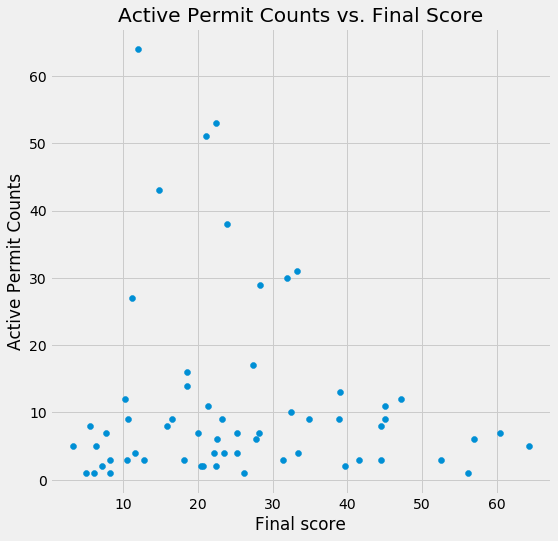

In [773]:
plt.figure(figsize=(8, 8))
plt.xlabel("Final score")
plt.ylabel("Active Permit Counts")
plt.scatter(permits_tracts_counts_finals['FinalScore'], permits_tracts_counts_finals['permit_totals'])
plt.title("Active Permit Counts vs. Final Score");

In [774]:
active_permits_dropna = permits_tracts_counts_finals[['FinalScore', 'permit_totals']].dropna()

# R^2 (coefficient of determination) regression score
regr = linear_model.LinearRegression()
regr.fit(active_permits_dropna[['FinalScore']], active_permits_dropna[['permit_totals']])
regr.score(active_permits_dropna[['FinalScore']], active_permits_dropna[['permit_totals']])


0.008487283724714412

In [775]:
mod = sm.OLS(active_permits_dropna[['FinalScore']], active_permits_dropna[['permit_totals']])
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:             FinalScore   R-squared (uncentered):                   0.263
Model:                            OLS   Adj. R-squared (uncentered):              0.251
Method:                 Least Squares   F-statistic:                              21.46
Date:                Thu, 02 Jul 2020   Prob (F-statistic):                    1.99e-05
Time:                        04:49:08   Log-Likelihood:                         -284.16
No. Observations:                  61   AIC:                                      570.3
Df Residuals:                      60   BIC:                                      572.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

### back to previous analysis using old method:

In [595]:
# groupby blocks to count how many active permits but not yet drilled wells in each block 
# selected two columns because don't want too many columns of the same output 

permits_blockcounts = permits_oil[['GEOID10','STATEFP10']].groupby('GEOID10').count().sort_values('STATEFP10', ascending=False)
permits_blockcounts = permits_blockcounts.rename(columns={'STATEFP10': 'permit_counts'})


In [597]:
permits_blockcounts.head()

,permit_counts
GEOID10,
081230025022053,193
081230025012006,183
081230025011202,107
081230025022047,104
080010085411178,101


In [646]:
test = permits_blockcounts.reset_index()

In [686]:
# 08123: Weld County: 66% of permits
# 08001: Adams County: 10% of permits

test['GEOID10'].str[:5].value_counts().head()

08123    470
08001     72
08045     43
08014     30
08005     20
Name: GEOID10, dtype: int64

In [598]:
permits_blockcounts.shape

(709, 1)

In [599]:
permits_counts_geo = permits_blockcounts.merge(col_blocks, on="GEOID10", how="inner")
permits_counts_geo['FIPS_tract_id'] = permits_counts_geo['GEOID10'].str[:11]
permits_counts_geo = gpd.GeoDataFrame(permits_counts_geo, geometry='geometry')
permits_counts_geo.head()

,GEOID10,permit_counts,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,NAME10,MTFCC10,UR10,UACE10,UATYPE,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,FIPS_tract_id
0,081230025022053,193,08,123,002502,2053,Block 2053,G5040,R,None,None,S,146033908,152933,+40.2699294,-104.4515854,"POLYGON ((-104.60274 40.20759, -104.60274 40.2...",08123002502
1,081230025012006,183,08,123,002501,2006,Block 2006,G5040,R,None,None,S,199078023,0,+40.9402030,-104.6864794,"POLYGON ((-104.80445 40.92370, -104.80354 40.9...",08123002501
2,081230025011202,107,08,123,002501,1202,Block 1202,G5040,R,None,None,S,40617523,0,+40.7713388,-104.0495411,"POLYGON ((-104.08826 40.77161, -104.08738 40.7...",08123002501
3,081230025022047,104,08,123,002502,2047,Block 2047,G5040,R,None,None,S,232287099,90038,+40.2024937,-104.4522830,"POLYGON ((-104.60294 40.14661, -104.60290 40.1...",08123002502
4,080010085411178,101,08,001,008541,1178,Block 1178,G5040,R,None,None,S,1853682,0,+39.9514353,-104.8925314,"POLYGON ((-104.90377 39.95032, -104.90364 39.9...",08001008541


##### trying with just the counts and not scores first (but this doesn't have the tract buffers)

In [698]:
permits_tracts_counts = permits_counts_geo[['FIPS_tract_id', 'STATEFP10']].groupby(['FIPS_tract_id']).count().reset_index().rename(columns={'STATEFP10':'permit_totals'})
permits_tracts_counts_finals = permits_tracts_counts.merge(colorado_final, on='FIPS_tract_id', how='inner')

In [700]:
permits_tracts_counts_finals.head()

,FIPS_tract_id,permit_totals,Unnamed: 0,NAME,state,lead_score,lead_rank,total_pop,poverty_score,poverty_rank,...,HD_rank,demographic_score,exposure_score,effects_score,sensitive_score,Pollution_Burden,Pop_Char,FinalScore,missing_values,Final_Rank
0,08001008353,9,1196,"Census Tract 83.53, Adams County, Colorado",8,0.033126,26.072874,7907.0,33.552548,69.733656,...,29.677419,68.940312,54.133729,58.377105,68.115118,73.592764,68.527715,45.056745,0,76.583333
1,08001008401,7,780,"Census Tract 84.01, Adams County, Colorado",8,0.089650,55.303644,4710.0,31.040340,64.568200,...,73.185484,50.793612,29.950249,35.544316,56.432838,41.798354,53.613225,20.021175,0,32.750000
2,08001008523,10,1181,"Census Tract 85.23, Adams County, Colorado",8,0.034933,26.882591,8345.0,15.170761,26.876513,...,73.185484,53.133154,53.613238,43.535045,53.577341,68.124920,53.355248,32.474434,0,58.250000
3,08001008540,9,526,"Census Tract 85.40, Adams County, Colorado",8,0.008114,9.230769,8039.0,4.652320,3.147700,...,61.491935,31.930774,60.494099,39.812527,38.381859,73.764942,35.156317,23.169242,0,41.000000
4,08001008541,17,527,"Census Tract 85.41, Adams County, Colorado",8,0.021885,20.242915,5795.0,4.745470,3.228410,...,93.508065,32.230044,64.078547,47.155068,44.346149,79.796903,38.288097,27.296582,0,48.666667


In [714]:
permits_tracts_counts_finals.columns

Index(['FIPS_tract_id', 'permit_totals', 'Unnamed: 0', 'NAME', 'state',
       'lead_score', 'lead_rank', 'total_pop', 'poverty_score', 'poverty_rank',
       'edu_score', 'edu_rank', 'lin_score', 'lin_rank', 'unemploy_score',
       'unemploy_rank', 'nonwhitePerc', 'nonwhite_rank', 'HouseBurden_score',
       'HouseBurden_rank', 'ozone_score', 'ozone_rank', 'diesel_score',
       'diesel_rank', 'toxics_score', 'toxics_rank', 'PM25_score', 'PM25_rank',
       'Avg_PTRAF', 'Avg_PTSDF', 'Avg_PRMP', 'Avg_PWDIS', 'Avg_PNPL',
       'PTRAF_rank', 'PTSDF_rank', 'PRMP_rank', 'PWDIS_rank', 'PNPL_rank',
       'asthma_score', 'asthma_rank', 'LB_score', 'LB_rank', 'HD_score',
       'HD_rank', 'demographic_score', 'exposure_score', 'effects_score',
       'sensitive_score', 'Pollution_Burden', 'Pop_Char', 'FinalScore',
       'missing_values', 'Final_Rank'],
      dtype='object')

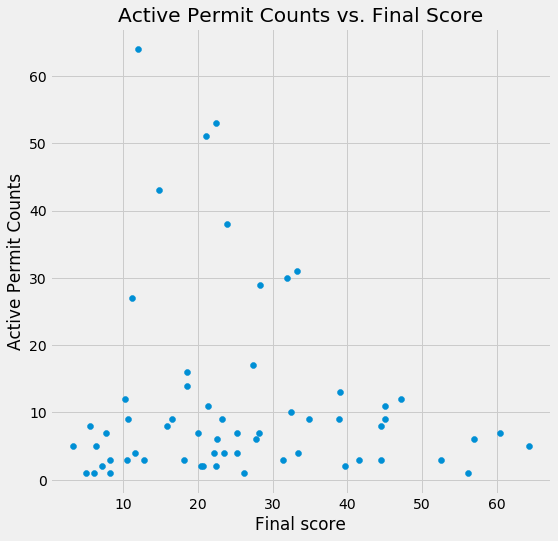

In [705]:
plt.figure(figsize=(8, 8))
plt.xlabel("Final score")
plt.ylabel("Active Permit Counts")
plt.scatter(permits_tracts_counts_finals['FinalScore'], permits_tracts_counts_finals['permit_totals'])
plt.title("Active Permit Counts vs. Final Score");

In [709]:
active_permits_dropna = permits_tracts_counts_finals[['FinalScore', 'permit_totals']].dropna()

# R^2 (coefficient of determination) regression score
regr = linear_model.LinearRegression()
regr.fit(active_permits_dropna[['FinalScore']], active_permits_dropna[['permit_totals']])
regr.score(active_permits_dropna[['FinalScore']], active_permits_dropna[['permit_totals']])


0.008487283724714412

In [711]:
mod = sm.OLS(active_permits_dropna[['FinalScore']], active_permits_dropna[['permit_totals']])
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:             FinalScore   R-squared (uncentered):                   0.263
Model:                            OLS   Adj. R-squared (uncentered):              0.251
Method:                 Least Squares   F-statistic:                              21.46
Date:                Wed, 01 Jul 2020   Prob (F-statistic):                    1.99e-05
Time:                        22:17:56   Log-Likelihood:                         -284.16
No. Observations:                  61   AIC:                                      570.3
Df Residuals:                      60   BIC:                                      572.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [720]:
active_permits_nonwhite = permits_tracts_counts_finals[['HouseBurden_rank', 'permit_totals']].dropna()
X = sm.add_constant(active_permits_nonwhite[['permit_totals']])
mod = sm.OLS(active_permits_nonwhite[['HouseBurden_rank']], X)
res = mod.fit()
print(res.summary()) 

                            OLS Regression Results                            
Dep. Variable:       HouseBurden_rank   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                   0.07076
Date:                Wed, 01 Jul 2020   Prob (F-statistic):              0.791
Time:                        22:23:31   Log-Likelihood:                -261.83
No. Observations:                  56   AIC:                             527.7
Df Residuals:                      54   BIC:                             531.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            41.6904      4.577      9.108

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


##### back to calculating a score for permits

In [706]:
permits_counts_geo.shape

(709, 19)

In [606]:
permits_counts_geo['Block_Area'] = permits_counts_geo.area

permits_w_areas = pd.merge(permits_counts_geo[['GEOID10','STATEFP10','FIPS_tract_id','permit_counts','Block_Area','geometry']], df_tracts[['FIPS_tract_id','Tract_Area']], on='FIPS_tract_id')

permits_w_areas['Tract_Proportion'] = permits_w_areas['Block_Area'] / permits_w_areas['Tract_Area']

permits_w_areas['permits_proportion'] = permits_w_areas['permit_counts'] * permits_w_areas['Tract_Proportion']

permits_w_areas.drop(columns={'permit_counts'}, inplace=True)

In [611]:
tracts_permits = permits_w_areas[['STATEFP10','FIPS_tract_id', 'permits_proportion']].groupby('FIPS_tract_id').sum()
tracts_permits = tracts_permits.rename(columns={'permits_proportion':'permits_score'})
tracts_permits['permits_rank'] = tracts_permits.rank(method='average', na_option='keep', pct=True)*100

In [616]:
tracts_permits.head()

,permits_score,permits_rank
FIPS_tract_id,,
08001008353,3.519685,77.272727
08001008401,0.151141,16.666667
08001008523,3.298516,75.757576
08001008540,7.554995,90.909091
08001008541,12.151292,95.454545


In [652]:
co_final_permits = tracts_permits.merge(colorado_final, on='FIPS_tract_id', how='inner')

In [653]:
co_final_permits.head()

,FIPS_tract_id,permits_score,permits_rank,Unnamed: 0,NAME,state,lead_score,lead_rank,total_pop,poverty_score,...,HD_rank,demographic_score,exposure_score,effects_score,sensitive_score,Pollution_Burden,Pop_Char,FinalScore,missing_values,Final_Rank
0,08001008353,3.519685,77.272727,1196,"Census Tract 83.53, Adams County, Colorado",8,0.033126,26.072874,7907.0,33.552548,...,29.677419,68.940312,54.133729,58.377105,68.115118,73.592764,68.527715,45.056745,0,76.583333
1,08001008401,0.151141,16.666667,780,"Census Tract 84.01, Adams County, Colorado",8,0.089650,55.303644,4710.0,31.040340,...,73.185484,50.793612,29.950249,35.544316,56.432838,41.798354,53.613225,20.021175,0,32.750000
2,08001008523,3.298516,75.757576,1181,"Census Tract 85.23, Adams County, Colorado",8,0.034933,26.882591,8345.0,15.170761,...,73.185484,53.133154,53.613238,43.535045,53.577341,68.124920,53.355248,32.474434,0,58.250000
3,08001008540,7.554995,90.909091,526,"Census Tract 85.40, Adams County, Colorado",8,0.008114,9.230769,8039.0,4.652320,...,61.491935,31.930774,60.494099,39.812527,38.381859,73.764942,35.156317,23.169242,0,41.000000
4,08001008541,12.151292,95.454545,527,"Census Tract 85.41, Adams County, Colorado",8,0.021885,20.242915,5795.0,4.745470,...,93.508065,32.230044,64.078547,47.155068,44.346149,79.796903,38.288097,27.296582,0,48.666667


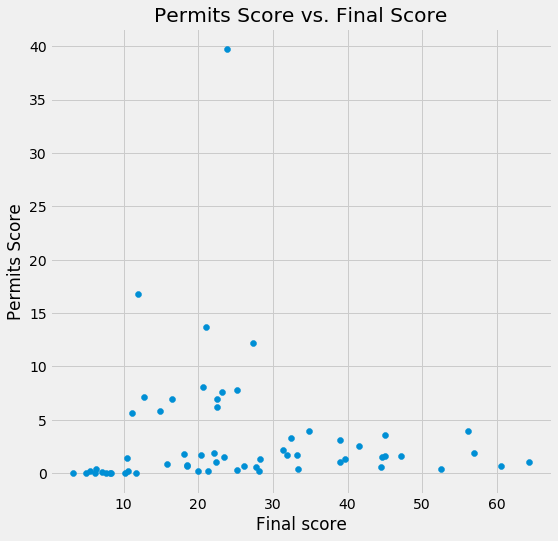

In [654]:
plt.figure(figsize=(8, 8))
plt.xlabel("Final score")
plt.ylabel("Permits Score")
plt.scatter(co_final_permits['FinalScore'], co_final_permits['permits_score'])
plt.title("Permits Score vs. Final Score");

In [656]:
rank_dropna = co_final_permits[['Final_Rank', 'permits_rank']].dropna()

# R^2 (coefficient of determination) regression score
regr = linear_model.LinearRegression()
regr.fit(rank_dropna[['Final_Rank']], rank_dropna[['permits_rank']])
regr.score(rank_dropna[['Final_Rank']], rank_dropna[['permits_rank']])


0.09646800338800432

In [659]:
# R^2 (coefficient of determination) regression score
scores_dropna = co_final_permits[['FinalScore', 'permits_score']].dropna()
regr = linear_model.LinearRegression()
regr.fit(scores_dropna[['FinalScore']], scores_dropna[['permits_score']])
regr.score(scores_dropna[['FinalScore']], scores_dropna[['permits_score']])


0.001363397596928273

## Research on weights <a id='weights_research'></a>

### Weights for wells vs. tanks vs. pits

__Pits seem to be worse environmentally than tanks__

This 2015 paper from Research the Future (https://pdfs.semanticscholar.org/6d06/8a9ff17cbd092710d2e8cdc789d0b0615b85.pdf) describes the United States Department of the Interior Bureau of Land Management (BLM) having the most stringent regulations on pits compared to tanks on page 29: 

"BLM is perhaps the most stringent regulator of pits, basically not allowing their use. In
2015, BLM released final standards for hydraulic fracturing on public and tribal lands, which
include a new requirement that all produced water be stored in “rigid, enclosed, covered, or
netted and screened above-ground tanks, subject to very limited exceptions in which lined pits
could be used” that may not exceed a 500-barrel capacity (BLM 2015). BLM’s justification for
this new requirement is based on the argument that tanks are less prone to leaking than pits, are
safer for wildlife, and will have fewer air emissions. In addition, BLM cited several benefits that
tanks afford to oil and gas operators, including quicker site preparation, increases in safety, and
fewer monitoring and mitigation requirements."

Also, in this Instruction Memorandum No. WY-2012-007 by the BLM from 2012 (need to find more recent policy...) on the "Management of Oil and Gas Exploration and Production Pits," (https://www.blm.gov/policy/im-wy-2012-007) closed tanks are preferred over open pits: 

"Use of enclosed tanks and closed loop or semi-closed loop systems is environmentally preferable to the use of open pits and is to be encouraged by the BLM. Open production pits are to be strongly discouraged. Closed tanks and systems minimize waste, entry by wildlife, fugitive emissions that affect air quality, and reduce the risk of soil and groundwater contamination. In addition, the use of tanks instead of pits expedites the ability to complete interim reclamation. Costs may be reduced with the use of tanks, particularly when the pit requires solidification or netting."

I'm assuming oil wells are the most environmentally damaging compared to tanks and pits because it is the actual site of drilling, however I haven't found exact research that cites something like this...

Then there are also the different levels of status for each facility, so an inactive well is probably worse than an active tank...

### Weights for different facility statuses

some context: https://www.hh-law.com/Articles/Oil-and-Gas-Articles/Abandoned-Oil-and-Gas-Wells-More-Than-Just-a-Rusty-Eyesore.shtml

definition of the statuses: https://cogcc.state.co.us/documents/about/COGIS_Help/Status_Codes.pdf

### Weighted average score for each block (wells, tanks, pits agg)

should I rank all of them against each other, or rank within type of facility, or rank within type of status? 

In [76]:
#for when we have weights: 

# # Need to adjust this so that columns that aren't in this dataset are included (ex. if this dataset doesn't happen to have
# # an abandoned tank but a future dataset does, need to have an abandon status column for tanks then)

# col_fac_df = col_blocks_buffered_df.merge(dfpivot_oil, on="GEOID10", how='left').rename(columns={'AC': "wells_AC",
#                                                                                                             'AL': 'wells_AL',
#                                                                                                             'CL': 'wells_CL',
#                                                                                                             'SU': 'wells_SU'})

# col_fac_df = col_fac_df.merge(dfpivot_pits, on="GEOID10", how='left').rename(columns={'AC': "pits_AC",
#                                                                                                             'AL': 'pits_AL',
#                                                                                                             'CL': 'pits_CL',
#                                                                                                             'UN': 'pits_UN'})

# col_fac_df = col_fac_df.merge(dfpivot_tanks, on="GEOID10", how='left').rename(columns={'AC': "tanks_AC",
#                                                                                                             'AL': 'tanks_AL',
#                                                                                                             'PR': 'tanks_PR',
#                                                                                                             'SI': 'tanks_SI',
#                                                                                                             'XX': 'tanks_XX'})

# col_fac_df = col_fac_df[['STATEFP10', 'GEOID10',
#        'NAME10','geometry',
#        'wells_AC', 'wells_AL', 'wells_CL', 'wells_SU', 'pits_AC', 'pits_AL',
#        'pits_CL', 'pits_UN', 'tanks_AC', 'tanks_AL','tanks_PR',
#        'tanks_SI', 'tanks_XX', 'wells_AC', 'wells_AL','wells_SU',
#        'pits_AC', 'pits_AL', 'pits_CL', 'pits_UN', 'tanks_AC', 'tanks_AL',
#        'CL', 'tanks_PR', 'tanks_SI', 'tanks_XX']]

# col_fac_df


## Account for surrounding states' oil and gas pollution carryover <a id='borders_carryover_research'></a>

Wyoming: http://pipeline.wyo.gov/legacywogcce.cfm

Nebraska: http://www.nogcc.ne.gov/NOGCCPublications.aspx

Kansas: http://www.kgs.ku.edu/PRS/petroDB.html

Oklahoma: http://www.occeweb.com/og/ogdatafiles2.htm

New Mexico: http://www.emnrd.state.nm.us/OCD/ocdgis.html

Arizona: http://welldata.azogcc.az.gov/textsearch.html

Utah: https://gis.utah.gov/data/energy/oil-gas/

National (ish): 

https://hifld-geoplatform.opendata.arcgis.com/datasets/oil-and-natural-gas-wells/data?page=9

http://www.noggateway.org/explore